# Balancing Robot Analysis

This notebook provides comprehensive analysis of the trained models and robot behavior.

In [1]:
import sys

sys.path.append("..")

import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from tqdm import tqdm

from src.balancing_robot.models import Actor, Critic, SimNet
from src.balancing_robot.environment import BalancerEnv
from src.balancing_robot.visualization import (
    plot_training_metrics,
    create_episode_animation,
    plot_predictions_comparison,
    plot_state_distributions,
)

## Load Models

In [2]:
# Load DDPG model
env = BalancerEnv()
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.shape[0]
max_action = float(env.action_space.high[0])

actor = Actor(state_dim, action_dim, max_action)
actor.load_state_dict(torch.load('logs/ddpg_training/best_actor.pt', map_location=torch.device('cpu'))['state_dict'])

# Load SimNet model
simnet_checkpoint = torch.load('logs/simnet_training/simnet_final.pt')
simnet = SimNet(
    state_dim=simnet_checkpoint['metadata']['state_dim'],
    action_dim=simnet_checkpoint['metadata']['action_dim'],
    hidden_dims=simnet_checkpoint['metadata']['hidden_dims']
)
simnet.load_state_dict(simnet_checkpoint['state_dict'])

# Create directories
log_dir = Path('logs/analysis')
log_dir.mkdir(parents=True, exist_ok=True)

c:\Users\eyalp\AppData\Local\Programs\Python\Python310\lib\site-packages\gymnasium\spaces\box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
c:\Users\eyalp\AppData\Local\Programs\Python\Python310\lib\site-packages\gymnasium\spaces\box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


## Compare Different Simulation Methods

In [3]:
def run_episode(env, actor, max_steps=500):
    """Run single episode and collect data."""
    state, _ = env.reset()
    states, actions, rewards = [], [], []

    for _ in range(max_steps):
        states.append(state)
        
        with torch.no_grad():
            state = torch.FloatTensor(state).unsqueeze(0).to("cpu")
            action = actor(state).cpu().numpy().flatten()
        next_state, reward, done, truncated, info = env.step(action)

        actions.append(action)
        rewards.append(reward)

        if done:
            break

        state = next_state

    return np.array(states), np.array(actions), np.array(rewards), info


# Create environments
physics_env = BalancerEnv()
simnet_env = BalancerEnv(simnet=simnet)

# Run episodes
num_episodes = 100
results = {
    "physics": {"rewards": [], "lengths": [], "states": []},
    "simnet": {"rewards": [], "lengths": [], "states": []},
    "hybrid": {"rewards": [], "lengths": [], "states": []},
}

for env_name, env in [
    ("physics", physics_env),
    ("simnet", simnet_env),
]:
    for _ in tqdm(range(num_episodes), desc=f"Running {env_name}"):
        states, actions, rewards, info = run_episode(env, actor)
        results[env_name]["rewards"].append(sum(rewards))
        results[env_name]["lengths"].append(len(rewards))
        results[env_name]["states"].append(states)

c:\Users\eyalp\AppData\Local\Programs\Python\Python310\lib\site-packages\gymnasium\spaces\box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
c:\Users\eyalp\AppData\Local\Programs\Python\Python310\lib\site-packages\gymnasium\spaces\box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(
Running simnet: 100%|██████████| 100/100 [00:18<00:00,  5.27it/s]


## Performance Analysis

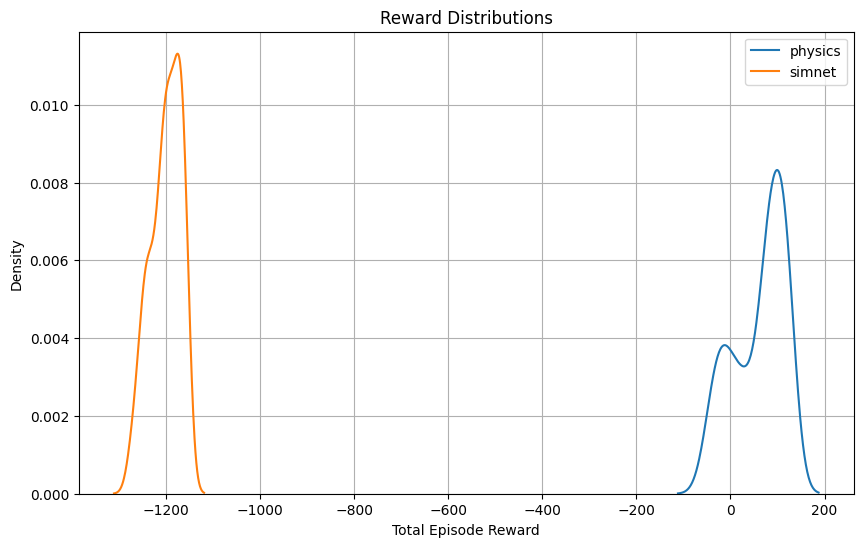

C:\Users\eyalp\AppData\Local\Temp\ipykernel_37428\3825986496.py:14: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(results[env_name]['lengths'], label=env_name)
C:\Users\eyalp\AppData\Local\Temp\ipykernel_37428\3825986496.py:14: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(results[env_name]['lengths'], label=env_name)
C:\Users\eyalp\AppData\Local\Temp\ipykernel_37428\3825986496.py:17: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


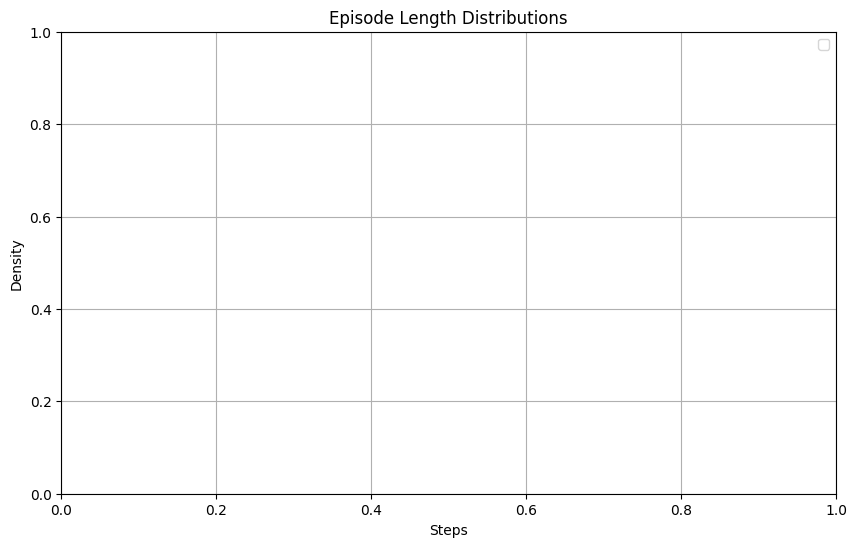

In [4]:
# Plot reward distributions
plt.figure(figsize=(10, 6))
for env_name in results:
    sns.kdeplot(results[env_name]['rewards'], label=env_name)
plt.title('Reward Distributions')
plt.xlabel('Total Episode Reward')
plt.legend()
plt.grid(True)
plt.show()

# Plot episode length distributions
plt.figure(figsize=(10, 6))
for env_name in results:
    sns.kdeplot(results[env_name]['lengths'], label=env_name)
plt.title('Episode Length Distributions')
plt.xlabel('Steps')
plt.legend()
plt.grid(True)
plt.show()

## State Space Analysis

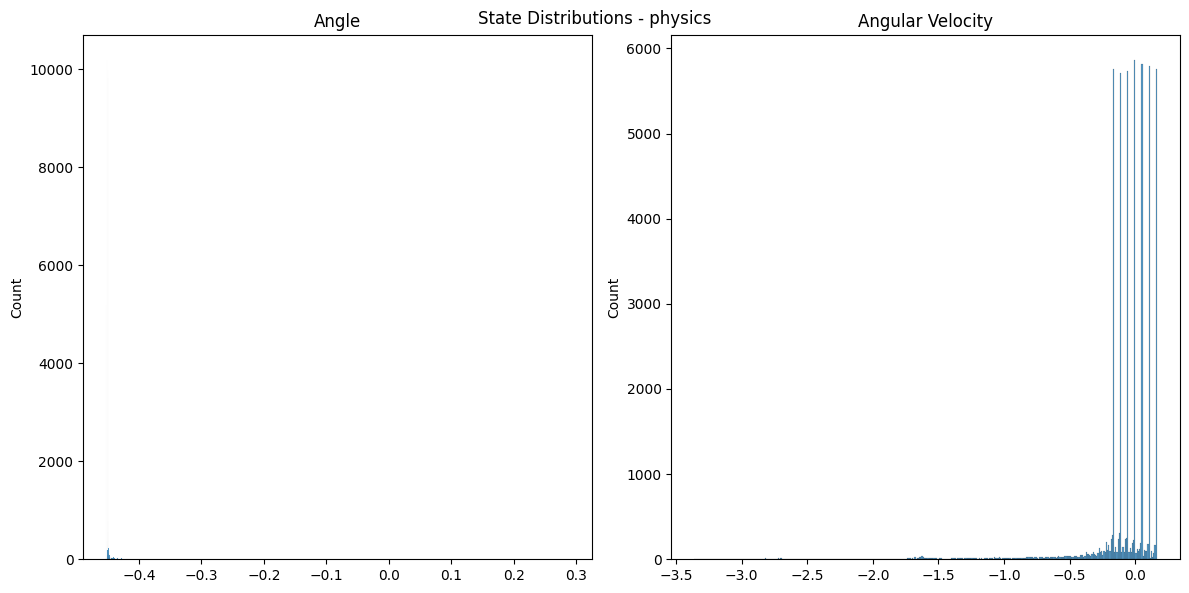

KeyboardInterrupt: 

Error in callback <function flush_figures at 0x0000020FE07671C0> (for post_execute), with arguments args (),kwargs {}:


KeyboardInterrupt: 

In [5]:
# Plot state distributions for each environment
for env_name in results:
    states = np.concatenate(results[env_name]['states'])
    fig = plot_state_distributions(
        states,
        save_path=f'logs/analysis/{env_name}_state_dist.png'
    )
    plt.suptitle(f'State Distributions - {env_name}')
    plt.show()

## Stability Analysis

In [ ]:
def analyze_stability(states):
    """Compute stability metrics for episode."""
    return {
        'max_angle': np.max(np.abs(states[:, 0])),
        'avg_angle': np.mean(np.abs(states[:, 0])),
        'max_pos': np.max(np.abs(states[:, 2])),
        'avg_pos': np.mean(np.abs(states[:, 2])),
        'angular_velocity_std': np.std(states[:, 1]),
        'position_velocity_std': np.std(states[:, 3])
    }

stability_metrics = {env_name: [] for env_name in results}

for env_name in results:
    for episode_states in results[env_name]['states']:
        metrics = analyze_stability(episode_states)
        stability_metrics[env_name].append(metrics)

# Plot stability metrics
metric_names = list(stability_metrics['physics'][0].keys())
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

for ax, metric in zip(axes.flat, metric_names):
    for env_name in results:
        values = [m[metric] for m in stability_metrics[env_name]]
        sns.kdeplot(values, label=env_name, ax=ax)
    ax.set_title(metric)
    ax.grid(True)
    ax.legend()

plt.tight_layout()
plt.show()

## Energy Analysis

In [ ]:
def compute_energy_metrics(states, actions):
    """Compute energy-related metrics."""
    kinetic_energy = 0.5 * (states[:, 1]**2 + states[:, 3]**2)
    potential_energy = 9.81 * (1 - np.cos(states[:, 0])) * 0.025  # mgl(1-cos(theta))
    control_effort = np.sum(actions**2)
    
    return {
        'avg_kinetic': np.mean(kinetic_energy),
        'max_kinetic': np.max(kinetic_energy),
        'avg_potential': np.mean(potential_energy),
        'max_potential': np.max(potential_energy),
        'total_control_effort': control_effort
    }

energy_metrics = {env_name: [] for env_name in results}

for env_name in results:
    for states, actions in zip(results[env_name]['states'],
                              results[env_name]['actions']):
        metrics = compute_energy_metrics(states, actions)
        energy_metrics[env_name].append(metrics)

# Plot energy metrics
metric_names = list(energy_metrics['physics'][0].keys())
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

for ax, metric in zip(axes.flat, metric_names):
    for env_name in results:
        values = [m[metric] for m in energy_metrics[env_name]]
        sns.kdeplot(values, label=env_name, ax=ax)
    ax.set_title(metric)
    ax.grid(True)
    ax.legend()

plt.tight_layout()
plt.show()

## Statistical Analysis

In [ ]:
from scipy import stats

def perform_statistical_analysis(results):
    """Perform statistical tests comparing different environments."""
    metrics = ['rewards', 'lengths']
    pairs = [('physics', 'simnet'), 
             ('physics', 'hybrid'), 
             ('simnet', 'hybrid')]
    
    analysis_results = {}
    
    for metric in metrics:
        analysis_results[metric] = {}
        
        for env1, env2 in pairs:
            # T-test
            t_stat, p_val = stats.ttest_ind(
                results[env1][metric],
                results[env2][metric]
            )
            
            # Effect size (Cohen's d)
            d = (np.mean(results[env1][metric]) - np.mean(results[env2][metric])) / \
                np.sqrt((np.var(results[env1][metric]) + np.var(results[env2][metric])) / 2)
            
            analysis_results[metric][f'{env1}_vs_{env2}'] = {
                't_statistic': t_stat,
                'p_value': p_val,
                'cohens_d': d
            }
    
    return analysis_results

# Perform analysis
stats_results = perform_statistical_analysis(results)

# Print results in a formatted table
for metric in stats_results:
    print(f"\n=== {metric.upper()} ===")
    print(f"{'Comparison':<20} {'t-stat':>10} {'p-value':>10} {'Cohen\'s d':>10}")
    print("-" * 50)
    
    for comparison, stats_dict in stats_results[metric].items():
        print(f"{comparison:<20} {stats_dict['t_statistic']:10.3f} "
              f"{stats_dict['p_value']:10.3f} {stats_dict['cohens_d']:10.3f}")

## SimNet Prediction Analysis

In [ ]:
def analyze_prediction_accuracy(simnet_env, physics_env, num_steps=1000):
    """Analyze accuracy of SimNet predictions compared to physics."""
    predictions = {'physics': [], 'simnet': []}
    states = []
    actions = []
    
    state = simnet_env.reset()
    for _ in range(num_steps):
        action = actor.select_action(state)
        
        # Get predictions from both models
        physics_pred, _, _, _, _ = physics_env.step(action)
        simnet_pred, _, _, _, _ = simnet_env.simnet(state, action)
        
        predictions['physics'].append(physics_pred)
        predictions['simnet'].append(simnet_pred)
        states.append(state)
        actions.append(action)
        
        # Step environment
        state, _, done, _ = simnet_env.step(action)
        if done:
            state = simnet_env.reset()
    
    return np.array(states), np.array(actions), predictions

# Analyze predictions
states, actions, predictions = analyze_prediction_accuracy(simnet_env, physics_env)

# Plot prediction differences
component_names = ['θ (rad)', 'θ̇ (rad/s)', 'x (m)', 'ẋ (m/s)', 'φ (rad)', 'φ̇ (rad/s)']
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

for i, (ax, name) in enumerate(zip(axes.flat, component_names)):
    physics = [p[i] for p in predictions['physics']]
    simnet = [p[i] for p in predictions['simnet']]
    
    ax.scatter(physics, simnet, alpha=0.5, s=1)
    ax.plot([-1, 1], [-1, 1], 'r--', alpha=0.8)
    ax.set_xlabel('Physics Prediction')
    ax.set_ylabel('SimNet Prediction')
    ax.set_title(name)
    ax.grid(True)

plt.tight_layout()
plt.show()

# Calculate error metrics
errors = np.array(predictions['physics']) - np.array(predictions['simnet'])
error_metrics = {
    'MSE': np.mean(errors**2, axis=0),
    'MAE': np.mean(np.abs(errors), axis=0),
    'Max Error': np.max(np.abs(errors), axis=0)
}

print("\nError Metrics:")
print(f"{'Metric':<10} {'θ':>10} {'θ̇':>10} {'x':>10} {'ẋ':>10} {'φ':>10} {'φ̇':>10}")
print("-" * 70)
for metric, values in error_metrics.items():
    print(f"{metric:<10} {values[0]:10.3f} {values[1]:10.3f} {values[2]:10.3f} {values[3]:10.3f} {values[4]:10.3f} {values[5]:10.3f}")